# Osborne mine


Geophysical Acquisition & Processing Section 2019. MIM Data from Mt Isa Inlier, QLD (P1029), magnetic line data, AWAGS levelled. Geoscience Australia, Canberra. http://pid.geoscience.gov.au/dataset/ga/142419

In [37]:
import os
import pooch
import pygmt
import pyproj
import numpy as np
import xarray as xr
import pandas as pd
import verde as vd

In [2]:
fname = pooch.retrieve(
    url="http://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/QLD/line/P1029/P1029-line-magnetic-AWAGS_MAG_2010.nc",
    known_hash="sha256:119b472da05365f0df4e9dc0b2d4b0e5c213705acb4f79efcaa07e1aeeb7242c",
)

In [38]:
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 3096.630339 Mb


In [3]:
data_nc = xr.open_dataset(fname)
data_nc

<xarray.Dataset>
Dimensions:            (point: 96100603, line: 11231)
Coordinates:
  * line               (line) float64 1.0 2.0 3.0 ... 1.123e+04 1.123e+04
Dimensions without coordinates: point
Data variables: (12/14)
    line_index         (point) float64 ...
    areaFlag           (line) float32 ...
    levelFlag          (line) float64 ...
    lineType           (line) float64 ...
    FID                (point) float64 ...
    altitude           (point) float64 ...
    ...                 ...
    mag_awagsLevelled  (point) float32 ...
    mag_microLevelled  (point) float32 ...
    mag_tieLevelled    (point) float64 ...
    latitude           (point) float64 ...
    longitude          (point) float64 ...
    crs                int8 ...
Attributes: (12/23)
    CreationTime:             Sun Dec 15 23:09:37 2019
    CreationMethod:           intrepid2netcdf.exe
    IntrepidSourceDataset:    ./mag_database_reformat_adjusted/intrepid/GSQP1...
    median_sample_spacing_m:  6.7
    geospatial_bounds:        POLYGON ((138.000707 -18.061092, 138.000733 -18...
    geospatial_lon_max:       141.34279740678033
    ...                       ...
    institution:              Commonwealth of Australia (Geoscience Australia)
    uuid:                     12ee23de-033c-44f2-8b63-932203d25f39
    Conventions:              CF-1.6, ACDD-1.3
    metadata_link:            http://pid.geoscience.gov.au/dataset/ga/142419
    keywords:                 AWAGS, Australia, Earth sciences, GADDS2.0, QLD...
    licence:                  CC BY 4.0 (C) Commonwealth of Australia (Geosci...

In [15]:
data_full = pd.DataFrame({
    "longitude": data_nc.longitude.data,
    "latitude": data_nc.latitude.data,
    "terrain_clearence_m": data_nc.altitude.data.astype(np.float32),
    "total_field_anomaly_nt": data_nc.mag_awagsLevelled.data.astype(np.float32),
    "flight_line": data_nc.line_index.data.astype(np.uint16),
})

In [32]:
srtm = vd.grid_to_table(pygmt.grdcut("@earth_relief_01s_g", region=vd.pad_region(region, 1/60)))
srtm

,lat,lon,z
0,-22.200000,140.466667,294.0
1,-22.200000,140.466944,294.0
2,-22.200000,140.467222,295.0
3,-22.200000,140.467500,295.0
4,-22.200000,140.467778,294.0
...,...,...,...
436916,-22.016667,140.648889,267.0
436917,-22.016667,140.649167,267.0
436918,-22.016667,140.649444,269.0
436919,-22.016667,140.649722,270.0


In [31]:
gda_to_wgs = pyproj.Transformer.from_crs("epsg:4283", "epsg:4326", always_xy=True)
longitude, latitude = gda_to_wgs.transform(
    data.longitude.values, 
    data.latitude.values,
)
data = data.assign(longitude=longitude, latitude=latitude)
data

,longitude,latitude,terrain_clearence_m,total_field_anomaly_nt,flight_line
0,140.483349,-22.033434,73.199997,321.717346,5649
1,140.483434,-22.033434,73.099998,323.876221,5649
2,140.483519,-22.033435,73.099998,326.033630,5649
3,140.483603,-22.033435,73.000000,328.209595,5649
4,140.483688,-22.033435,72.900002,330.373840,5649
...,...,...,...,...,...
121779,140.584702,-22.183009,76.199997,428.274139,5817
121780,140.584701,-22.183081,76.300003,428.174408,5817
121781,140.584700,-22.183158,76.500000,428.074707,5817
121782,140.584699,-22.183230,76.599998,427.975006,5817


In [32]:
srtm = vd.grid_to_table(pygmt.grdcut("@earth_relief_01s_g", region=vd.pad_region(region, 1/60)))
srtm

,lat,lon,z
0,-22.200000,140.466667,294.0
1,-22.200000,140.466944,294.0
2,-22.200000,140.467222,295.0
3,-22.200000,140.467500,295.0
4,-22.200000,140.467778,294.0
...,...,...,...
436916,-22.016667,140.648889,267.0
436917,-22.016667,140.649167,267.0
436918,-22.016667,140.649444,269.0
436919,-22.016667,140.649722,270.0


In [33]:
nearest = vd.ScipyGridder(method="linear")
nearest.fit((srtm.lon, srtm.lat), srtm.z)
srtm_height = nearest.predict((data.longitude, data.latitude))
data = data.assign(
    topography_srtm_sea_level_m=srtm_height
)
data

,longitude,latitude,terrain_clearence_m,total_field_anomaly_nt,flight_line,topography_srtm_sea_level_m
0,140.483349,-22.033434,73.199997,321.717346,5649,267.000000
1,140.483434,-22.033434,73.099998,323.876221,5649,267.000000
2,140.483519,-22.033435,73.099998,326.033630,5649,267.000000
3,140.483603,-22.033435,73.000000,328.209595,5649,267.000000
4,140.483688,-22.033435,72.900002,330.373840,5649,267.276231
...,...,...,...,...,...,...
121779,140.584702,-22.183009,76.199997,428.274139,5817,237.242927
121780,140.584701,-22.183081,76.300003,428.174408,5817,236.831339
121781,140.584700,-22.183158,76.500000,428.074707,5817,236.551994
121782,140.584699,-22.183230,76.599998,427.975006,5817,236.287912


In [25]:
reducer = vd.BlockReduce(np.mean, spacing=0.0005)
(lon, lat), (mag, h) = reducer.filter(
    (data.longitude, data.latitude), (data.total_field_anomaly_nt, data.topography_srtm_sea_level_m)
)
mag.size

20772

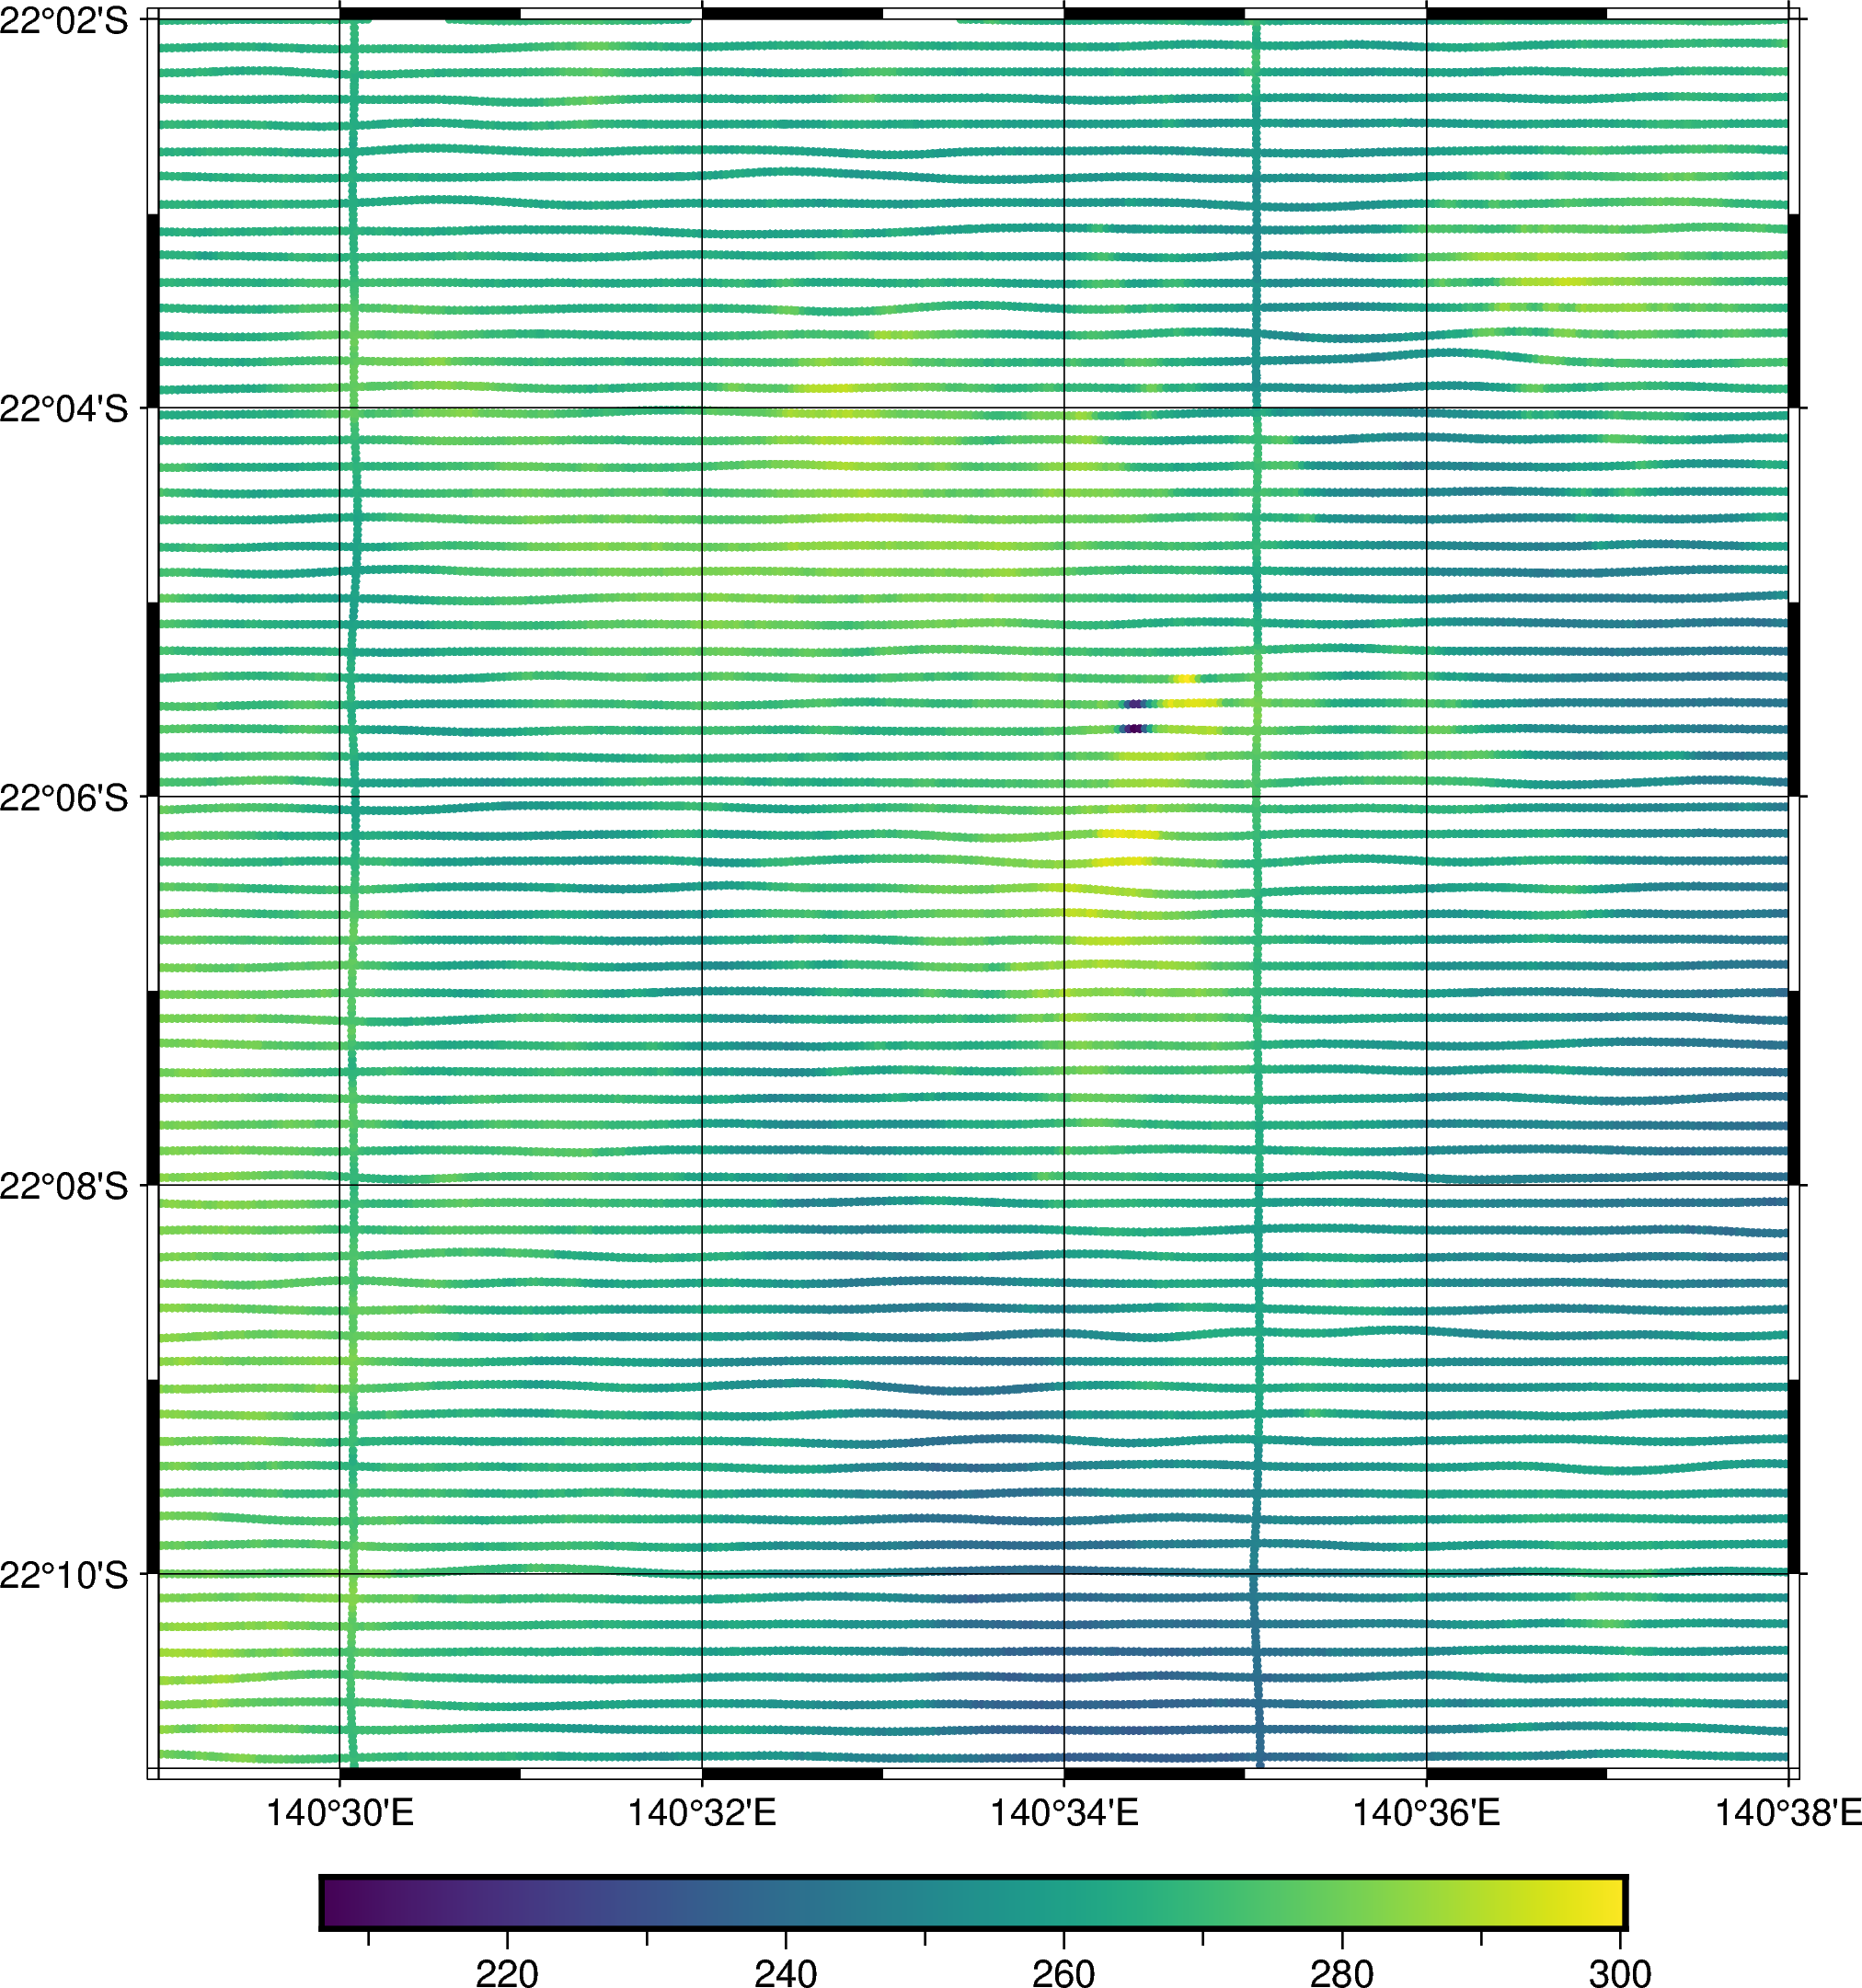

In [26]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[h.min(), h.max()])
fig.plot(
    x=lon,
    y=lat,
    projection="M15c",
    region=region,
    color=h,
    style="c0.075c",
    cmap=True,
)
fig.colorbar(frame="af", position="JBC+o0/1c")
fig.basemap(frame="afg")
fig.show()

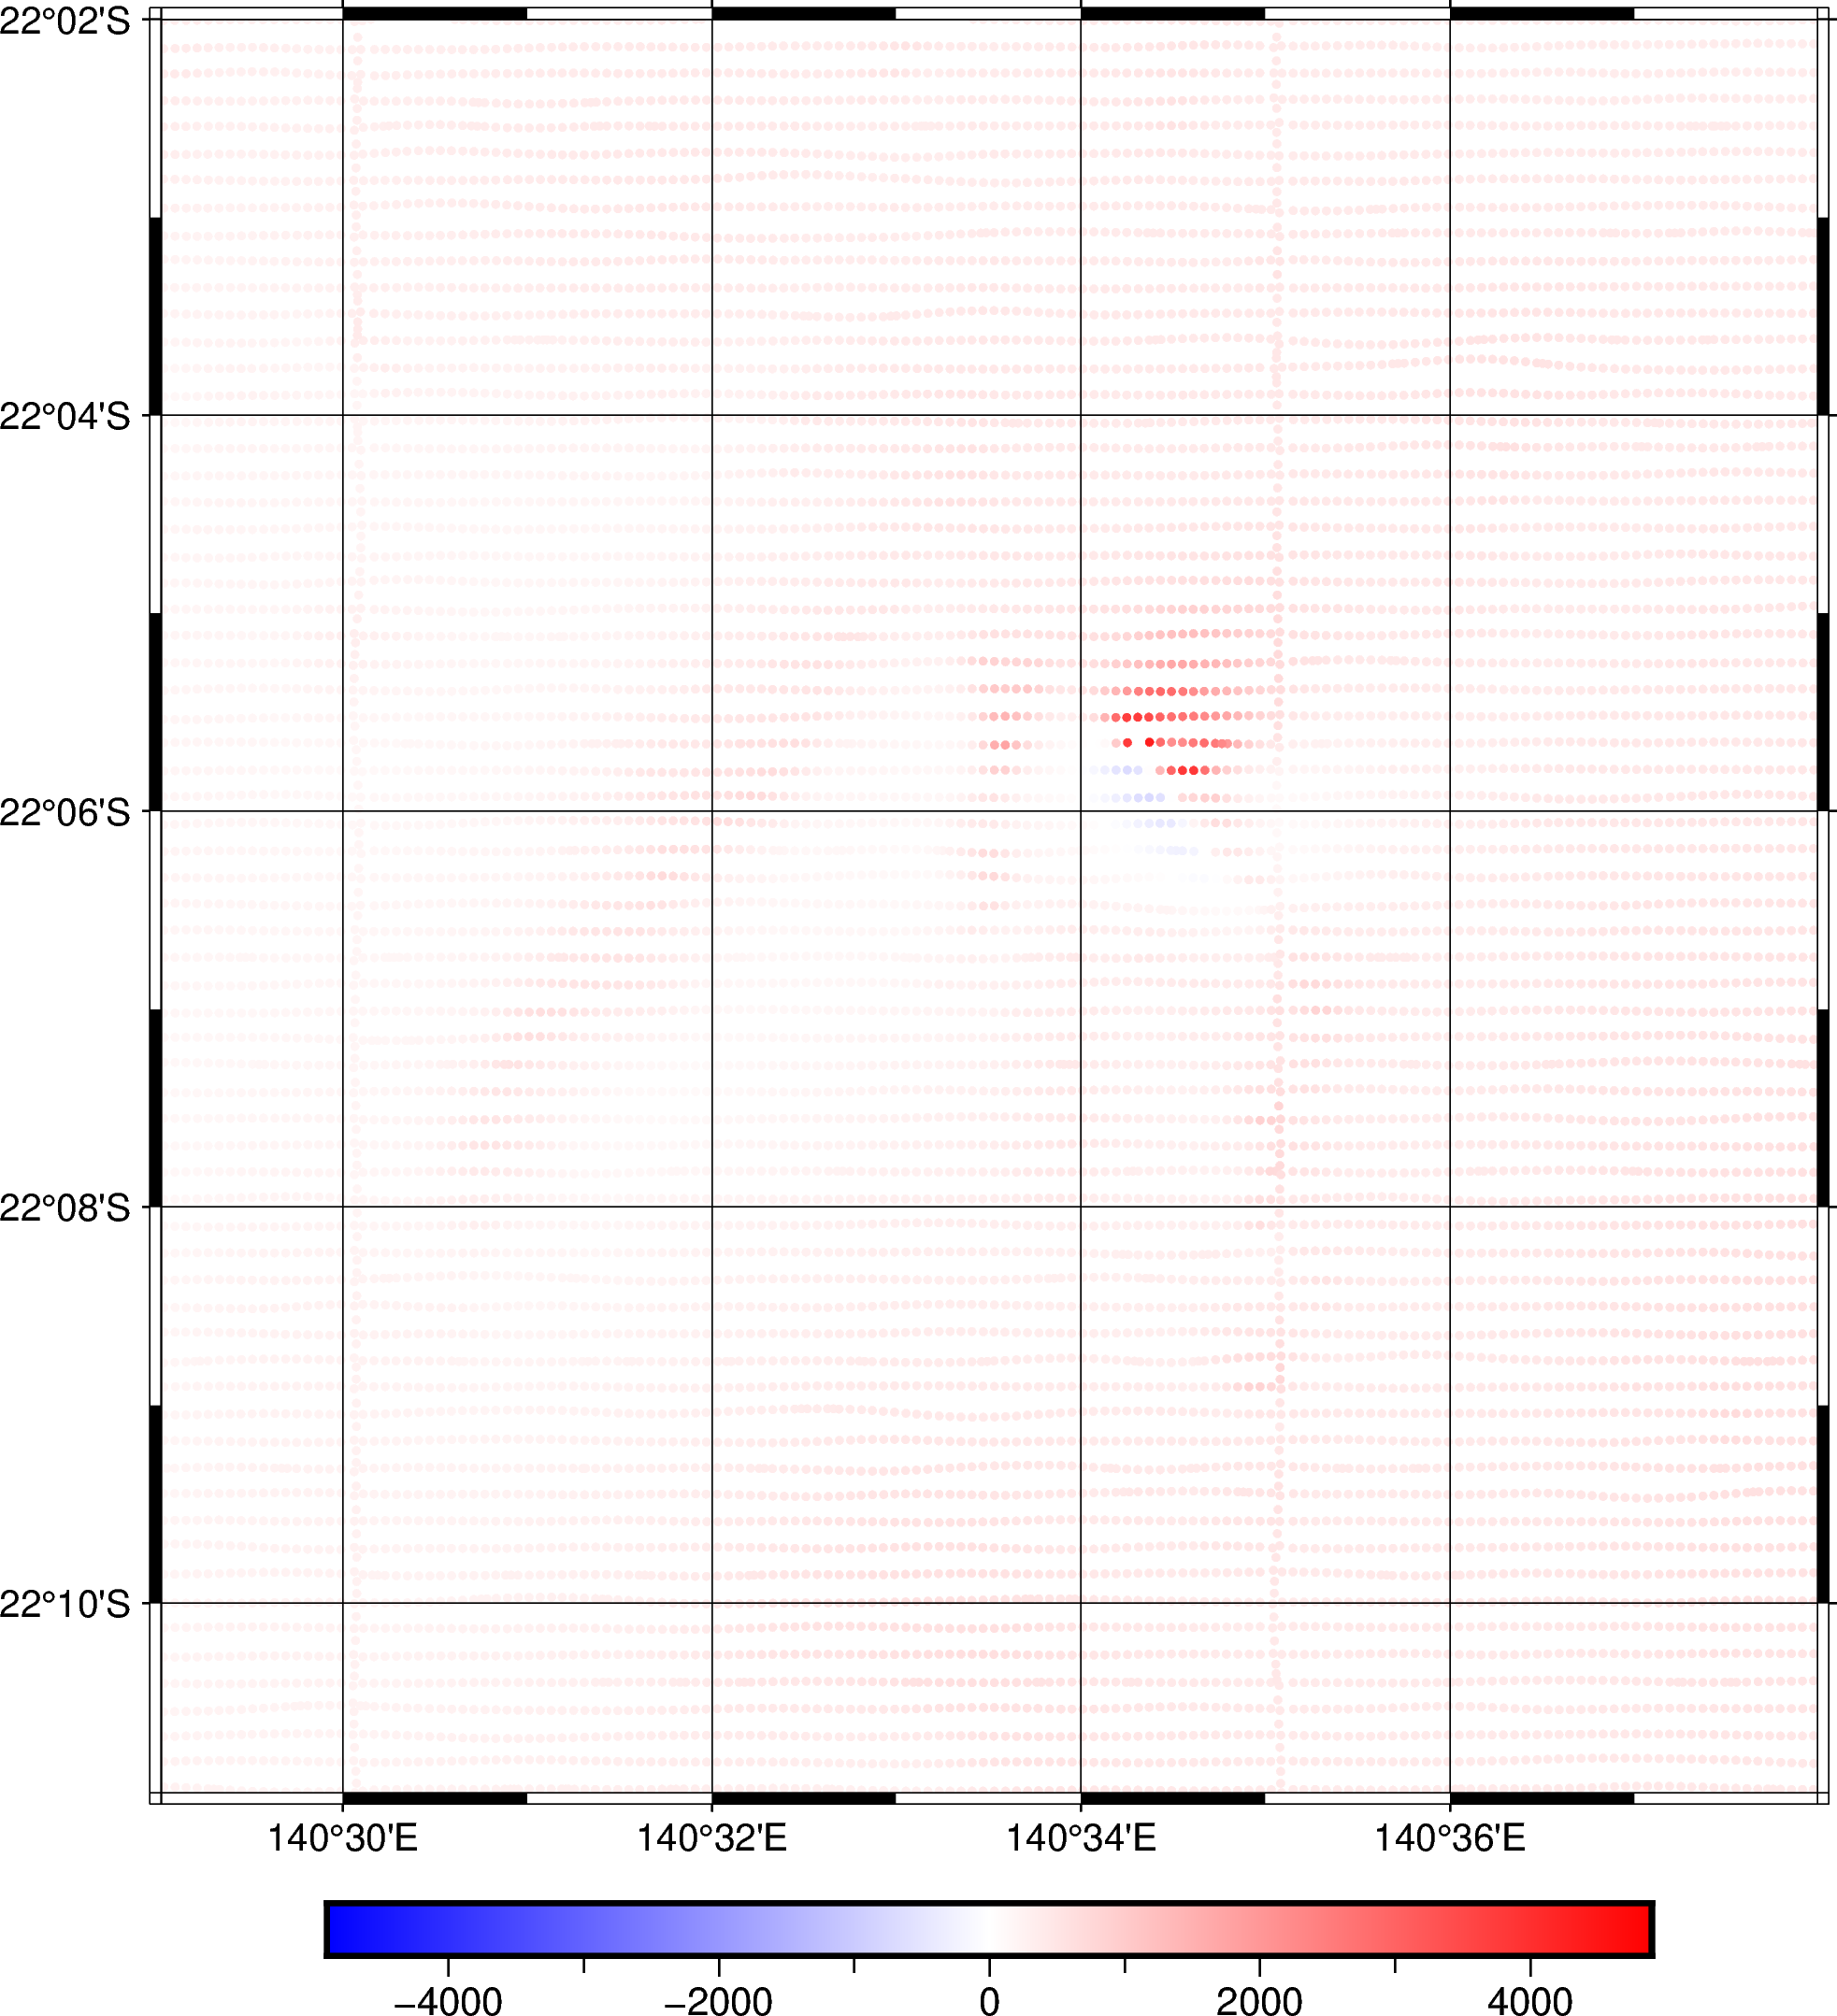

In [43]:
fig = pygmt.Figure()
scale = 0.9*vd.maxabs(mag)
pygmt.makecpt(cmap="polar+h", series=[-scale, scale])
fig.plot(
    x=lon,
    y=lat,
    projection="M15c",
    region=vd.get_region((lon, lat)),
    color=mag,
    style="c0.075c",
    cmap=True,
)
fig.colorbar(frame="af", position="JBC+o0/1c")
# Olympic Dam
#fig.plot(x=136.89, y=-30.49, style="c0.1c")
fig.basemap(frame="afg")
fig.show()

In [44]:
nn = vd.ScipyGridder(method="linear").fit((lon, lat), mag)
grid = nn.grid(spacing=1 / 60 / 60)

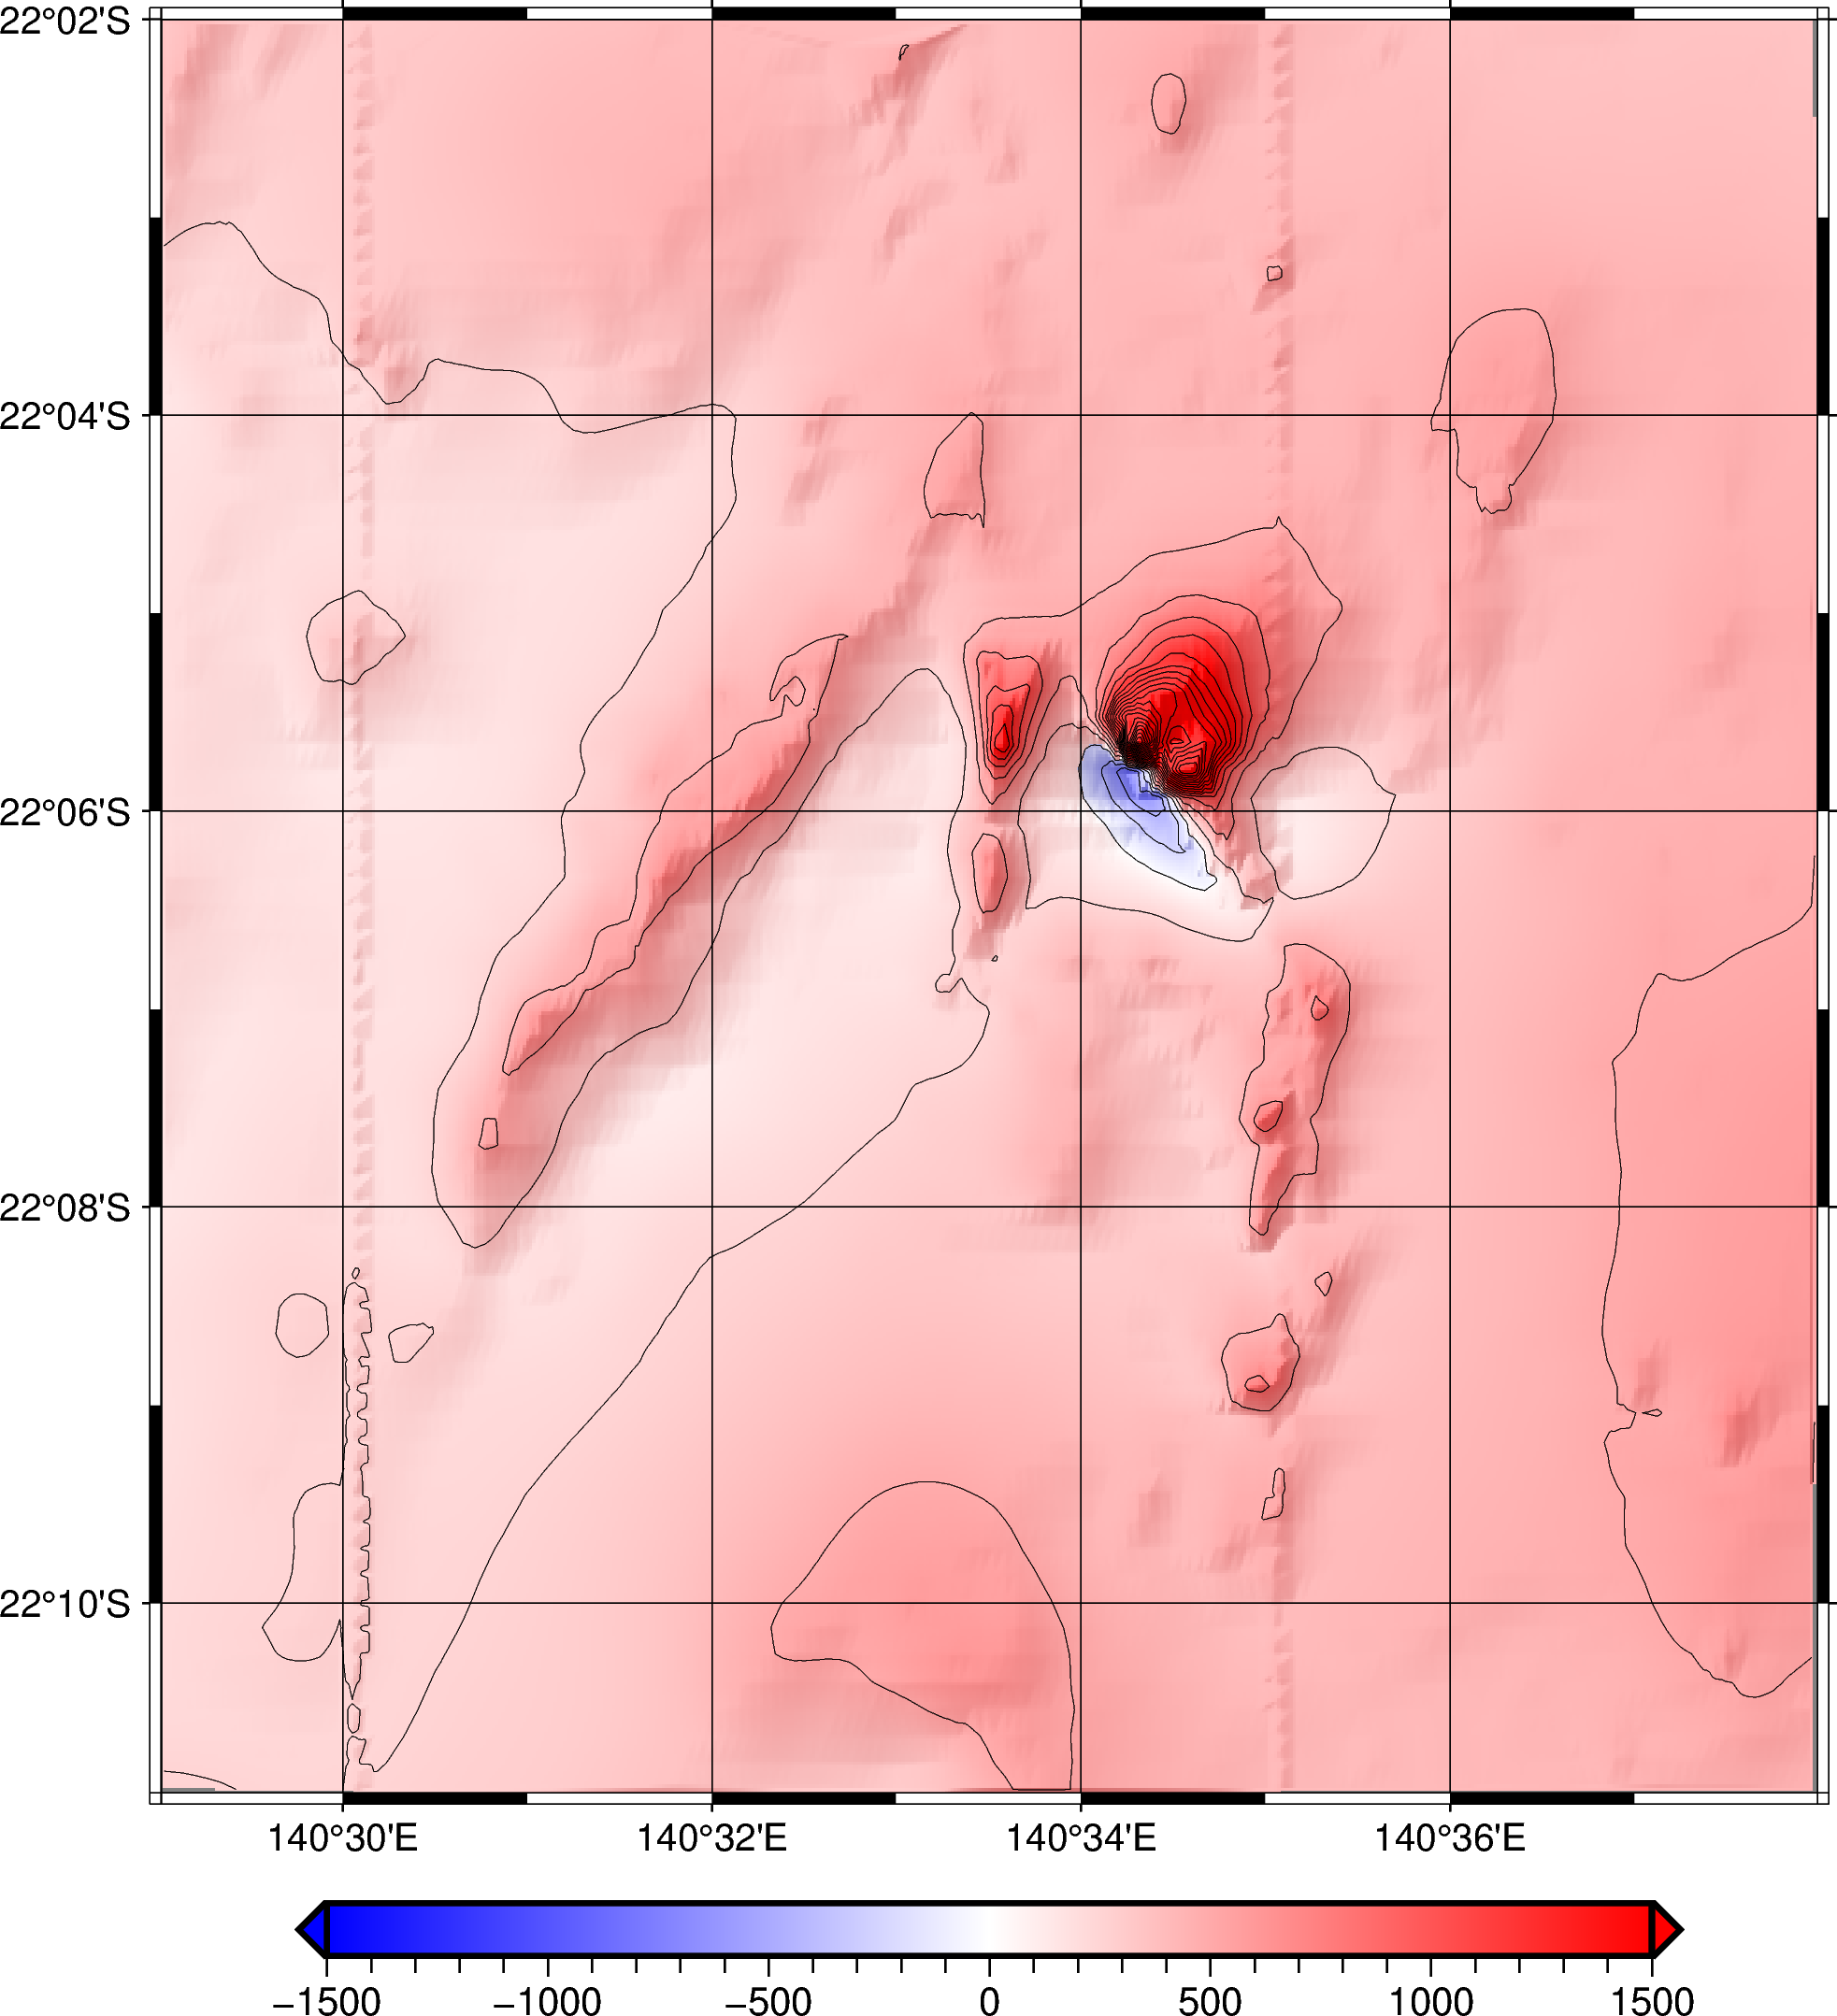

In [45]:
fig = pygmt.Figure()
scale = 0.80*vd.maxabs(mag)
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.grdimage(
    grid.scalars,
    projection="M15c",
    cmap=True,
    shading="+nt0.3",
)
fig.colorbar(frame="af", position="JBC+o0/1c+e")
fig.grdcontour(
    grid.scalars,
    interval=250,
    #limit="-1500/2000",
    pen="0.1p",
)
# Olympic Dam
fig.plot(x=136.89, y=-30.49, style="c0.1c")
fig.basemap(frame="afg")
fig.show()

In [34]:
data

,longitude,latitude,terrain_clearence_m,total_field_anomaly_nt,flight_line,topography_srtm_sea_level_m
0,140.483349,-22.033434,73.199997,321.717346,5649,267.000000
1,140.483434,-22.033434,73.099998,323.876221,5649,267.000000
2,140.483519,-22.033435,73.099998,326.033630,5649,267.000000
3,140.483603,-22.033435,73.000000,328.209595,5649,267.000000
4,140.483688,-22.033435,72.900002,330.373840,5649,267.276231
...,...,...,...,...,...,...
121779,140.584702,-22.183009,76.199997,428.274139,5817,237.242927
121780,140.584701,-22.183081,76.300003,428.174408,5817,236.831339
121781,140.584700,-22.183158,76.500000,428.074707,5817,236.551994
121782,140.584699,-22.183230,76.599998,427.975006,5817,236.287912


In [36]:
export = pd.DataFrame({  
    "flight_line": data.flight_line, 
    "longitude": data.longitude.map(lambda x: "{:.6f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.6f}".format(x)),    
    "terrain_clearence_m": data.terrain_clearence_m.map(lambda x: "{:.1f}".format(x)),   
    "topography_srtm_sea_level_m": data.topography_srtm_sea_level_m.map(lambda x: "{:.1f}".format(x)),   
    "total_field_anomaly_nt": data.total_field_anomaly_nt.map(lambda x: "{:.1f}".format(x)), 
})
export

,flight_line,longitude,latitude,terrain_clearence_m,topography_srtm_sea_level_m,total_field_anomaly_nt
0,5649,140.483349,-22.033434,73.2,267.0,321.7
1,5649,140.483434,-22.033434,73.1,267.0,323.9
2,5649,140.483519,-22.033435,73.1,267.0,326.0
3,5649,140.483603,-22.033435,73.0,267.0,328.2
4,5649,140.483688,-22.033435,72.9,267.3,330.4
...,...,...,...,...,...,...
121779,5817,140.584702,-22.183009,76.2,237.2,428.3
121780,5817,140.584701,-22.183081,76.3,236.8,428.2
121781,5817,140.584700,-22.183158,76.5,236.6,428.1
121782,5817,140.584699,-22.183230,76.6,236.3,428.0


In [39]:
fname = "osborne-magnetic.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

osborne-magnetic.csv.xz
size: 0.602488 Mb
md5:93e032db87ff7e979763e8639cce1338
sha256:0b8291f531262278a4771d6a3088d681b9a2afb2a308c8acdf88d400da3b2e91
